# Creating a CNN with PyTorch

## Import the Libraries

In [1]:
# Install PyTorch
import sys
! {sys.executable} -m pip install --upgrade torch
! {sys.executable} -m pip install --upgrade torchvision

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Requirement already up-to-date: torch in /data/anaconda/envs/py35/lib/python3.5/site-packages (1.0.1)
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: torchvision in /data/anaconda/envs/py35/lib/python3.5/site-packages (0.2.1)
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Libraries imported - ready to use PyTorch 1.0.1


### Load Data

In [2]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Now load the images from the shapes folder
data_path = 'resized_images/'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)

['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']


### Define a Neural Network Model

In [3]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=12):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 24 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 24 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 24 input channels, and generates 48 outputs
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
                
        # A drop layer deletes 50% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.5)
        
        # Our 128x128 image tensors will be pooled three times with a kernel size of 2. 128/2/2/2 is 16.
        # So our feature tensors are now 32 x 32, and we've generated 48 of them so our array is 16x16x48
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=16 * 16 * 48, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after convolution 1 and pool
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after convolution 2 and pool
        x = F.relu(self.pool(self.conv2(x)))
        
        # Use a relu activation function after convolution 2)
        x = F.relu(self.conv2(x))
        
        # Use a relu activation function after convolution 2
        x = F.relu(self.conv2(x))
        
         # Use a relu activation function after convolution 3 and pool
        x = F.relu(self.pool(self.conv3(x)))
        
        # Select some features to drop to prevent overfitting
        x = self.drop(x)
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 16 * 16 * 48)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return F.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.5)
  (fc): Linear(in_features=12288, out_features=12, bias=True)
)


### Train the Model

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    return train_loss / len(train_loader.dataset)
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    test_loss /= len(test_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return test_loss
    
    
# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 35 epochs
epochs = 35
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set [0/1485 (0%)] Loss: 2.481163
Training set [500/1485 (33%)] Loss: 2.087548
Training set [1000/1485 (67%)] Loss: 1.422337
Validation set: Average loss: 0.0231, Accuracy: 445/637 (70%)

Epoch: 2
Training set [0/1485 (0%)] Loss: 1.169366
Training set [500/1485 (33%)] Loss: 1.235734
Training set [1000/1485 (67%)] Loss: 0.737658
Validation set: Average loss: 0.0118, Accuracy: 505/637 (79%)

Epoch: 3
Training set [0/1485 (0%)] Loss: 0.599859
Training set [500/1485 (33%)] Loss: 0.701836
Training set [1000/1485 (67%)] Loss: 0.460211
Validation set: Average loss: 0.0096, Accuracy: 534/637 (84%)

Epoch: 4
Training set [0/1485 (0%)] Loss: 0.521148
Training set [500/1485 (33%)] Loss: 0.517546
Training set [1000/1485 (67%)] Loss: 0.395054
Validation set: Average loss: 0.0079, Accuracy: 551/637 (86%)

Epoch: 5
Training set [0/1485 (0%)] Loss: 0.333035
Training set [500/1485 (33%)] Loss: 0.488449
Training set [1000/1485 (67%)] Loss: 0.339621
Validation set: Avera

### View the Loss History

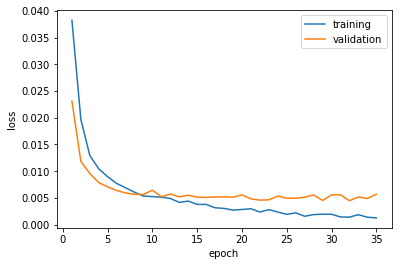

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Save the Model

In [6]:
# Save the model weights
model_file = 'gear-classifier.pth'
torch.save(model.state_dict(), model_file)
print("Model saved.")

# Delete the existing model variable
del model

Model saved.


### Use the Model with New Data

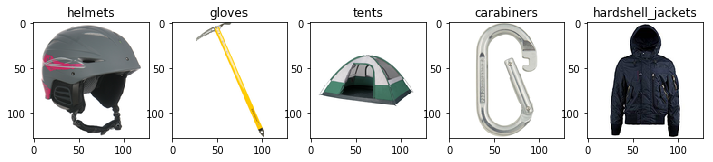

In [7]:
# Helper function to make image square
def reshape_image(img, size): 
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
  
    # return the resized image
    return np.array(newimg)

# Function to predict the class of an image
def predict_image(classifier, image_array):
    from PIL import Image
   
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # These are the classes our model can predict
    class_names = ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of each input image
    predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)

# Predict class for new data
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image_urls = []
image_urls.append('http://images.the-house.com/giro-g10mx-mtgy-07.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://ecx.images-amazon.com/images/I/41TNdO0o-LL._SX342_QL70_.jpg')

size = (128,128)

img_array = []

for url_idx in range(len(image_urls)):
    # Get the image
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    img = reshape_image(img, size)
    img_array.append(img)
    
# Create a new model instance and load the weights
model = Net(num_classes=len(classes))
model.load_state_dict(torch.load(model_file))
    
predicted_classes = predict_image(model, np.array(img_array))

fig = plt.figure(figsize=(12, 8))
idx = 0
for predicted_class in predicted_classes:
    a=fig.add_subplot(1,len(image_urls),idx+1)
    img = img_array[idx]
    imgplot = plt.imshow(img)
    a.set_title(predicted_class)
    idx += 1

